# Verification of Shell Elements' Normal Vectors Consistency

***

In our previous notebooks we observed that both an [unreinforced](06_Verification_of_SOL_106_Nonlinear_Buckling_Method.ipynb) and a [reinforced box beam](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb) follow a stable equilibrium path when loaded with a concentrated tip bending force larger than the linear buckling load predicted by SOL 105. Both structures showed a buckled-like deformation shape of the top skin as the applied load exceeded the linear buckling load. This behavior suggests an analogy with the natural equilibrium path of the broken supercritical pitchfork of the [Euler's column](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb). In other words, while a supercritical pitchfork bifurcation is probably present in the equilibrium manifold of the box beam, we observe a broken supercritical pitchfork because at least one of the symmetry of the problem is broken.

The break of symmetry can have both both physical and numerical causes. As a consequence, we need to rule out the latter kind to be confident that we are observing a physical behavior.

In this notebook we are going to investigate one of the possible numerical causes of the bifurcation break: the inconsistency of the direction of the elements' normal vectors. To preserve the symmetry of the problem, the normals of all elements of our box beam have to point either inward or outward. If there is a mixture of the two orientations, the symmetry of the problem is broken numerically. For the reinforced box beam, also the normals of all the elements of the ribs have to point in the same direction, that is to say either towards the root or towards the tip of the box beam.

We investigate both the unreinforced and reinforced box beam cases.

* [Unreinforced box beam](#unreinforced)
* [Reinforced box beam](#reinforced)
* [Conclusion](#conclusion)

## Unreinforced box beam <a name="unreinforced"></a>

***

We consider the same unreinforced box beam model that we used in our previous notebooks and we define the planform and cross-sectional properties.

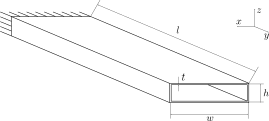

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '04_BoxBeamGeometry.svg'))

In [2]:
AR = 9   # aspect ratio - 2*b/w (the length of the box beam corresponds to half the span of the CRM wingbox)
w = 1e3   # width [mm]
l = AR*w/2  # length [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f"""
Box beam dimensions:
- width: {w/1e3:.1f} m
- length: {l/1e3:.1f} m
- height: {h/1e3:.1f} m
- wall thickness: {t:.1f} mm""")


Box beam dimensions:
- width: 1.0 m
- length: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


Let's discretize our geometry and create the bdf input, using the functions `mesh_box` and `create_base_bdf_input` from the `box_beam_utils` module. We are going to prescribe a large linear size for the shell elements, as we only need to check the orientation of the elements' normals and we don't need to run any numerical analysis. For the same reason we use dummy values for the material properties.

In [3]:
from resources import box_beam_utils  # module with useful functions to work with box beam problems

nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, length=l, height=h,
                                                                             element_length=h)  # discretize geometry
unreinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=1, poisson_ratio=1, density=1,
                                                                 shell_thickness=t,
                                                                 nodes_xyz_array=nodes_coordinates_array,
                                                                 nodes_connectivity_matrix=nodes_connectivity_matrix)  # create BDF object

subcase=0 already exists...skipping


We define the function `find_nodes_centroids_normals` to find the coordinates of the nodes and of the centroid of each element and also its normal vector.

In [4]:
import numpy as np

def find_nodes_centroids_normals(bdf_input):
    # Initialize arrays with coordinates and vector components
    nodes = np.empty((len(bdf_input.elements), 4, 3))
    centroids = np.empty((len(bdf_input.elements), 3))
    normals = np.empty((len(bdf_input.elements), 3))
    # Iterate through the elements of the bdf input
    for count, (eid, elem) in enumerate(bdf_input.elements.items()):
        nodes[count] = elem.get_node_positions()  # get the array with the coordinates of the nodes belonging to the element
        _, centroid, normal = elem.AreaCentroidNormal()  # find the coordinates of the centroid and the components of the normal vector of the element
        centroids[count] = centroid  # add coordinates of centroid to appropriate array
        normals[count] = normal  # add components of normal vector to appropriate array
    # Return arrays with nodes' coordinates, centroids' coordinates and normal vectors' components
    return nodes, centroids, normals

Let's call `find_nodes_centroids_normals` for our unreinforced box beam and let's discern the elements associated with the different structural parts: top skin, bottom skin, front spar and rear spar.

In [5]:
nodes_coordinates, centroids_coordinates, normal_vectors = find_nodes_centroids_normals(unreinforced_box_beam_bdf)
tolerance = h/100  # define geometric tolerance to discern the different structural parts
top_skin_indices = np.where(np.abs(centroids_coordinates[:, 2] - h/2) < tolerance)[0]  # find indices of elements belonging to the top skin
bottom_skin_indices = np.where(np.abs(centroids_coordinates[:, 2] + h/2) < tolerance)[0]  # find indices of elements belonging to the bottom skin
front_spar_indices = np.where(np.abs(centroids_coordinates[:, 0]) < tolerance)[0]  # find indices of elements belonging to the front spar
rear_spar_indices = np.where(np.abs(centroids_coordinates[:, 0] - w) < tolerance)[0]  # find indices of elements belonging to the rear spar
box_beam_parts = {'Top skin': top_skin_indices,
                  'Bottom skin': bottom_skin_indices,
                  'Front spar': front_spar_indices,
                  'Rear spar': rear_spar_indices}

Now we define the function `plot_elements_normals` to plot the elements and their normal for each structural part. We then use the function to visualize the normal vectors of the elements for the unreinforced box beam.

Top skin


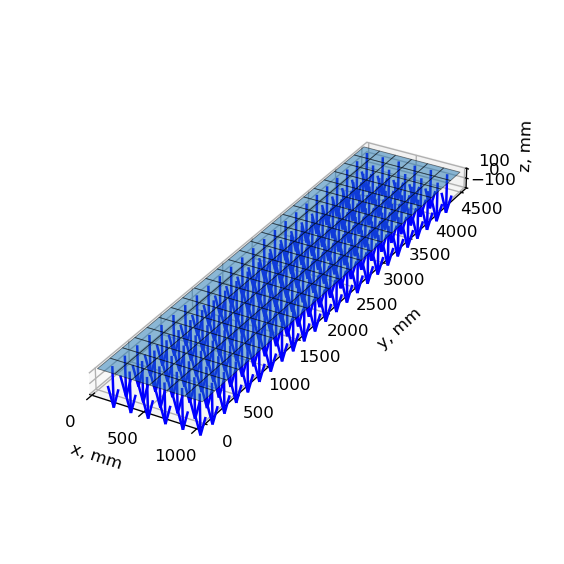

Bottom skin


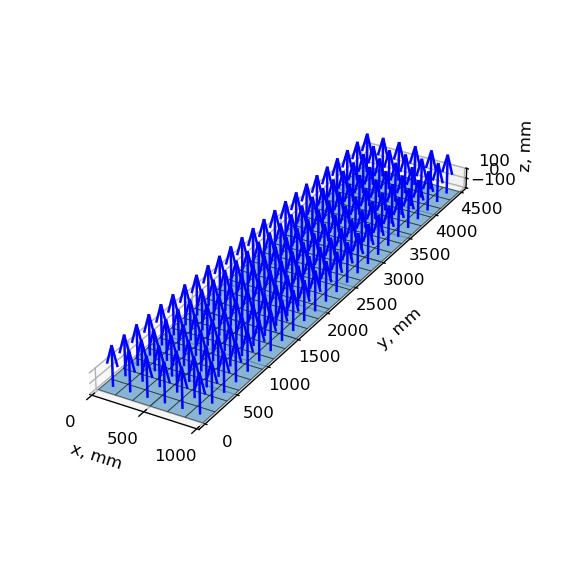

Front spar


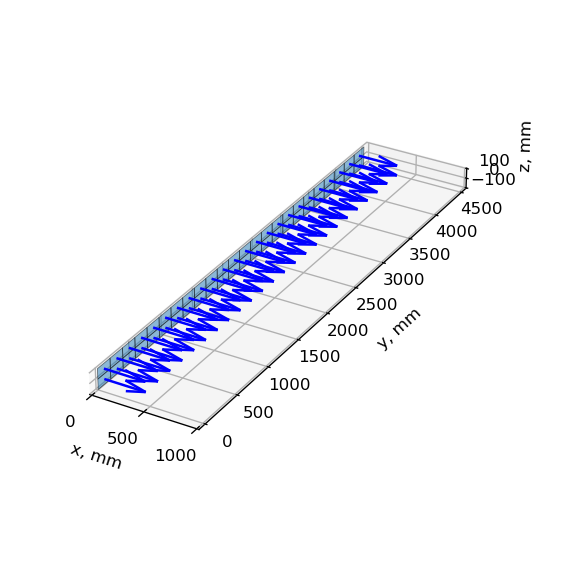

Rear spar


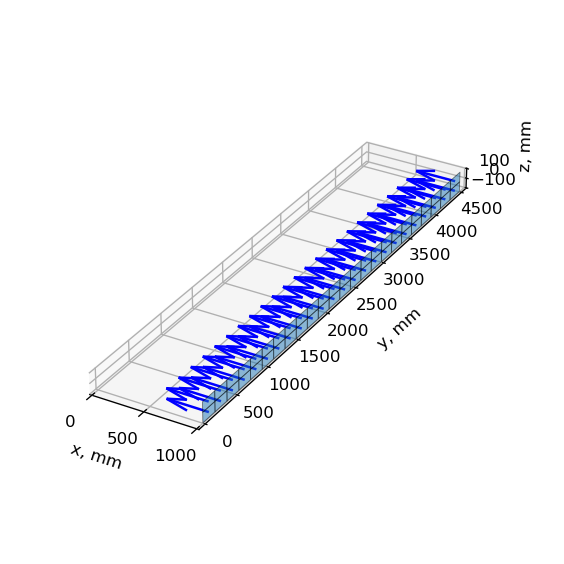

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_elements_normals(nodes, centroids, normals, parts):
    # Define limit for the axes range
    bounds = np.array([[np.amin(nodes[:, :, 0]), np.amax(nodes[:, :, 0])],
                       [np.amin(nodes[:, :, 1]), np.amax(nodes[:, :, 1])],
                       [np.amin(nodes[:, :, 2]), np.amax(nodes[:, :, 2])]])
    # Define list to set the aspect ratio of the plot
    aspect_ratio = [x[1]-x[0] for x in list(bounds)]
    # Iterate through the structural parts
    for part, indices in parts.items():
        print(part)
        # Create figure and axes
        fig = plt.figure(tight_layout=True)
        ax = fig.add_subplot(111, projection='3d')
        # Plot elements
        pc = Poly3DCollection(nodes[indices, :, :], linewidths=.5, alpha=.5)
        pc.set_edgecolor('k')
        ax.add_collection3d(pc)
        # Plot normal vectors
        ax.quiver(centroids[indices, 0], centroids[indices, 1], centroids[indices, 2],
                  normals[indices, 0], normals[indices, 1], normals[indices,2],
                  length=400, color='blue', arrow_length_ratio=.5)
        # Set axes label
        ax.set_xlabel("x, mm")
        ax.set_ylabel("y, mm")
        ax.set_zlabel("z, mm")
        # Set aspect ratio
        ax.set_box_aspect(aspect_ratio)
        # Set axes limits
        ax.set_xlim(bounds[0, :])
        ax.set_ylim(bounds[1, :])
        ax.set_zlim(bounds[2, :])
        # Adjust number of ticks of x and z axes
        ax.locator_params(axis='x', nbins=3)
        ax.locator_params(axis='z', nbins=2)
        # Adjust ticks label of y- and z-axis
        ax.tick_params(axis='y', which='major', pad=25)
        ax.tick_params(axis='z', which='major', pad=6)
        # Adjust axis label y and z axes
        ax.yaxis.labelpad = 70
        ax.zaxis.labelpad = 10
        # Show plot
        plt.show()

plt.rcParams['figure.dpi'] = 120 # set default dpi of figures
plot_elements_normals(nodes_coordinates, centroids_coordinates, normal_vectors, box_beam_parts)

We observe that all normal vectors are oriented inwards and as a consequence we can state that they have a consistent orientation.

## Reinforced box beam <a name="reinforced"></a>

***

Let's take a look at the reinforced box beam now. We use the same geometry employed in our [last notebook](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb).

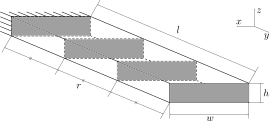

In [7]:
SVG(filename=os.path.join('resources', '08_BoxBeamGeometry.svg'))

In [8]:
ribs_spacing = w/2
no_ribs = int(np.ceil(l/ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # calculate y-coordinates of the ribs

# Print information to screen
np.set_printoptions(precision=0)
print(f"Number of ribs: {no_ribs:.0f}")
print(f"Ribs\' y-coordinate [mm]:")
print(ribs_y_locations)

Number of ribs: 10
Ribs' y-coordinate [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


Now we generate a mesh of our reinforced box beam and we create the corresponding bdf input. This time we use the function `mesh_box_beam_with_pyvista`, which employs the `pyvista` library to create the mesh.

In [9]:
reinforced_box_beam_mesh = box_beam_utils.mesh_box_beam_with_pyvista(ribs_y_coordinates=ribs_y_locations, width=w,
                                                                     height=h, element_length=h)  # discretize geometry using pyvista
nodes_xyz_array = reinforced_box_beam_mesh.points  # find coordinates of the nodes
nodes_connectivity_matrix = reinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]  # find connectivity matrix
reinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=1, poisson_ratio=1, density=1,
                                                               shell_thickness=t, nodes_xyz_array=nodes_xyz_array,
                                                               nodes_connectivity_matrix=nodes_connectivity_matrix)

subcase=0 already exists...skipping


Once again we use the functions `find_nodes_centroids_normal` and the `plot_elements_normals` to find the normal vectors of every element of the structure and plot them.

Top skin


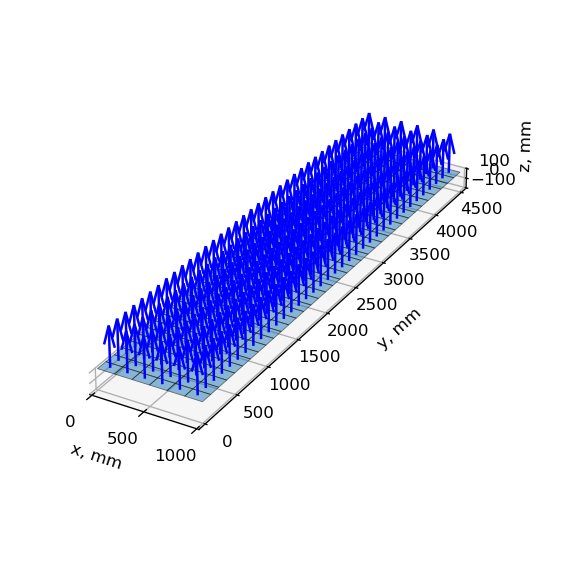

Bottom skin


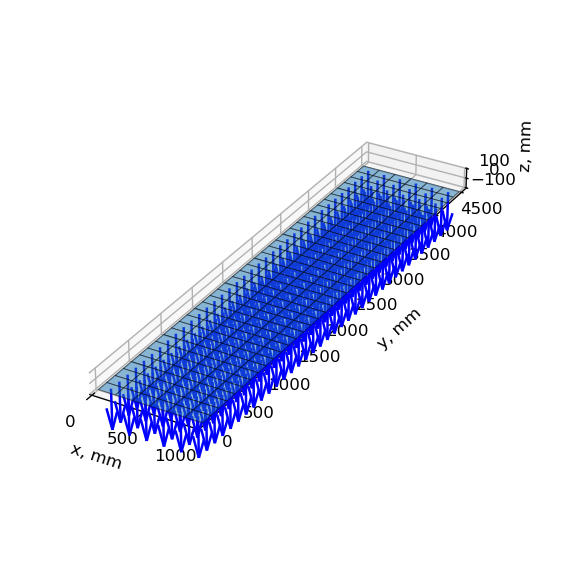

Front spar


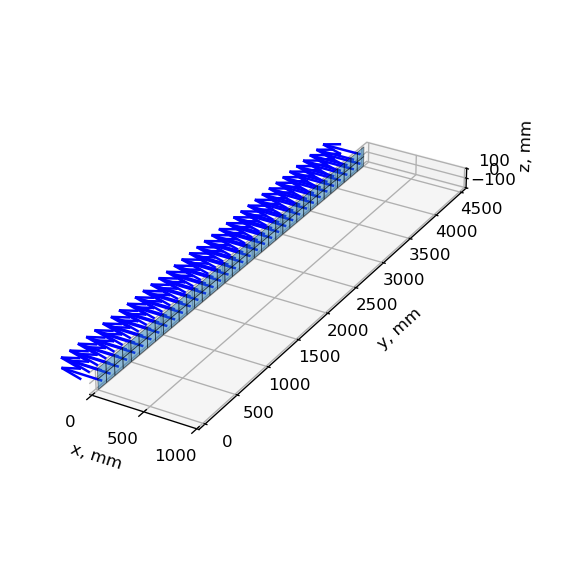

Rear spar


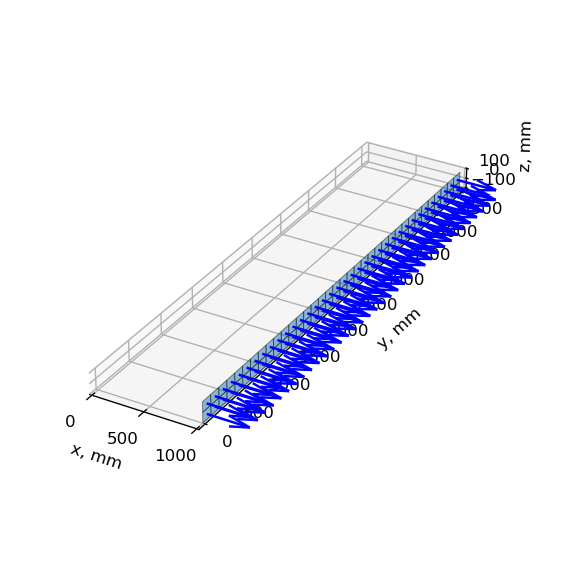

Ribs


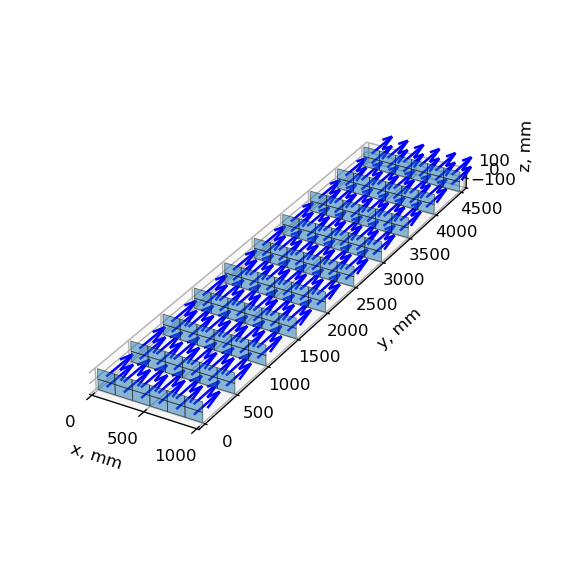

In [10]:
# Find normal vectors and coordinates of nodes and centroids
nodes_coordinates, centroids_coordinates, normal_vectors = find_nodes_centroids_normals(reinforced_box_beam_bdf)

# Find indices corresponding to the different structural parts
top_skin_indices = np.where(np.abs(centroids_coordinates[:, 2] - h/2) < tolerance)[0]
bottom_skin_indices = np.where(np.abs(centroids_coordinates[:, 2] + h/2) < tolerance)[0]
front_spar_indices = np.where(np.abs(centroids_coordinates[:, 0]) < tolerance)[0]
rear_spar_indices = np.where(np.abs(centroids_coordinates[:, 0] - w) < tolerance)[0]
ribs_indices = np.where(np.abs(centroids_coordinates[:, 1] - ribs_y_locations[:, np.newaxis]) < tolerance)[1]
box_beam_parts = {'Top skin': top_skin_indices,
                  'Bottom skin': bottom_skin_indices,
                  'Front spar': front_spar_indices,
                  'Rear spar': rear_spar_indices,
                  'Ribs': ribs_indices}

# Plot normal vectors
plot_elements_normals(nodes_coordinates, centroids_coordinates, normal_vectors, box_beam_parts)

In this case we notice that the normal vectors of the elements of the top and bottom skins and of the front and rear spars are oriented outwards, differently from the case of the unreinforced box beam. This difference stems from the fact that in the previous case we used the function `mesh_box` to create the mesh, which defines the nodes of the elements in an explicit way, while in this case we used the function `mesh_box_beam_with_pyvista`, which uses the `Plane` class of the `pyvista` library to create the different components of the mesh. Evidently, the `Plane` class defines the nodes of the elements in a different order, which leads to the different orientation of the normal vectors.

Nevertheless, the normal vectors of the outer shell elements of the box beam are consistently oriented outwards, and the normal vectors of the ribs are consistently oriented towards the tip of the box beam. As a consequence, we can state that the normal vectors of the elements of the reinforced box beam are all consistently oriented.

## Conclusion <a name="conclusion"></a>

In this notebook we have shown that the direction of the elements' normal vectors of our box beam is consistent for both the unreinforced and the reinforced configuration. We can conclude that the direction of the elements' normal vectors cannot be the cause of the bifurcation break.